In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorly as tl

Using numpy backend.


## Load previously compiled data

The raw (ping-by-ping) data were averaged to get mean volume backscattering strengh (MVBS) and then cleaned up by PCP. This is the same set of data I used to run the Matlab PALM-NMF.

Note that **all echograms in this notebook are plotted upside-down**, so the DVM you see you opposite of what actually happens. In reality the animals move toward the surface during the night and move downward during the day.

In [3]:
# Load PCP-cleaned MVBS data
MVBS_path = '/home/wu-jung/code_git/ooi_sonar/sample_data/'
MVBS_fname = '20150817-20151017_MVBS_PCPcleaned.h5'

import h5py
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),'r')

In [4]:
# Load low-rank data
L = np.array(f['L'])
L_sep = np.array(f['L_sep'])
L_plot = np.array(f['L_plot'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_per_day_mvbs = np.array(f['ping_per_day_mvbs'])
ping_time = np.array(f['ping_time'])
f.close()

The data is organized with dimension [frequency x number of days x depth x time of day].

In [5]:
L_sep.shape

(3, 62, 37, 144)

The 3 frequencies of data look like:

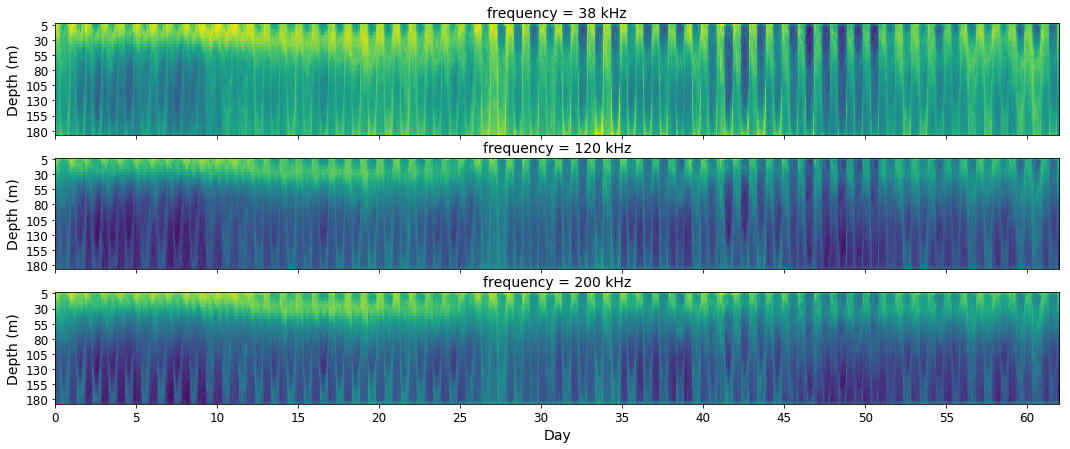

In [83]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep[f,:,::-1,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,65*144,144*5))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)
plt.show()

Here the y-axis starts at 5 m because I've cut off the top 5 m of data which include a lot of super strong surface reflection that can throw out the decomposition.

The data within each day look like:

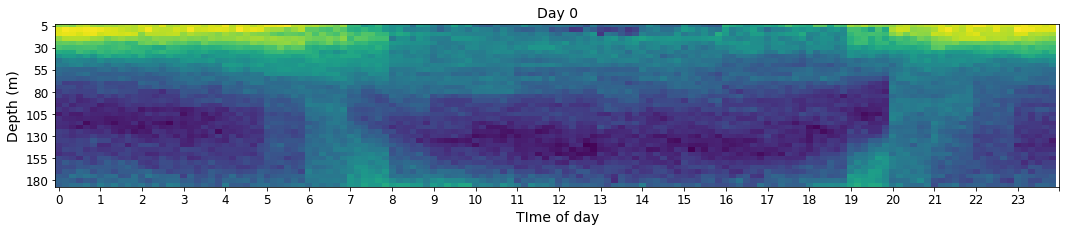

In [79]:
fig = plt.figure(figsize=(18,3))
plt.imshow(L_sep[0,0,::-1,:].squeeze(),aspect='auto')
plt.xticks(range(0,150,6), range(24), fontsize=12)
plt.yticks(np.arange(0,37,5), (np.arange(0,37,5)+1)*depth_bin_size, fontsize=12)
plt.xlabel('TIme of day', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.title('Day 0',fontsize=14)
plt.show()

Note how each hour is a vertical "stripe." This is because the data were collected from only the first 20 mins of each hour, so there is a discontinuity in the raw data itself.

## Parafac decomposition on freq=38kHz data

Here I am using 1 frequency only just to see how things look like. I am not sure if throwing the 3 frequencies and making a 4D tensor makes sense because for that dimension there are only 3 frequencies of observation and this would force the parafac to have max rank=3...

In [11]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import parafac, non_negative_parafac
from tensorly.tenalg import kronecker, khatri_rao

In [12]:
sonar_tensor = tl.tensor(L_sep[0,:,:,:])

In [13]:
sonar_tensor.shape

(62, 37, 144)

Below I am setting the decomposition rank = 4 because by observation (at the bottom of this notebook) that seems to be a good number. I'll discuss this more in this section.

I tried both the regular and the non-negative version of parafac. The former seems to give better results (with the same decomposition rank) but the latter is physically more sound (somewhat... we are operating in log-domain still here, so this is not entirely correct).

### Decompose with different rank

In [131]:
rank_all = np.arange(3,11,1)
factors_kruskal = []
factors_kruskal_nn = []
recons_tensor = []
recons_tensor_nn = []

for r in rank_all:
    print('computing rank=%d'%r)
    factors_kruskal.append(parafac(sonar_tensor, rank = r))
    factors_kruskal_nn.append(non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = r))
    recons_tensor.append(tl.kruskal_to_tensor(factors_kruskal[-1]))
    recons_tensor_nn.append(tl.kruskal_to_tensor(factors_kruskal_nn[-1]))

computing rank=3
computing rank=4
computing rank=5
computing rank=6
computing rank=7
computing rank=8
computing rank=9
computing rank=10


## Compare reconstruction with different rank

### Regular parafac

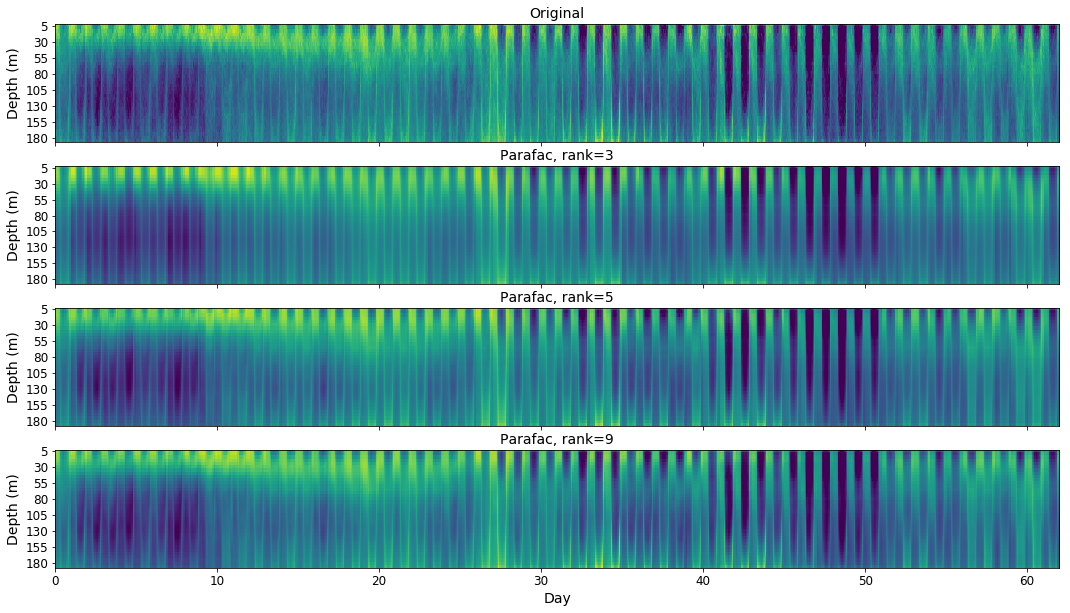

In [132]:
rank_wanted = [3,5,9]
rank_idx = np.array([np.argwhere(rank_all==x).squeeze() for x in rank_wanted])

fig,ax = plt.subplots(len(rank_wanted)+1,1,figsize=(18,10),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[:,::-1,:]),mode=1),aspect='auto',
            vmax=-57, vmin=-85)
ax[0].set_title('Original', fontsize=14)
for seq,r in enumerate(rank_idx):
    ax[seq+1].imshow(tl.unfold(tl.tensor(recons_tensor[r][:,::-1,:]),mode=1), aspect='auto',
                     vmax=-57, vmin=-85)
    ax[seq+1].set_title('Parafac, rank=%d'%rank_all[r], fontsize=14)
for f in range(4):
    ax[f].set_xticks(range(0,62*144,144*10))
    ax[f].set_xticklabels(range(0,62,10))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
plt.show()

###  Non-negative parafac

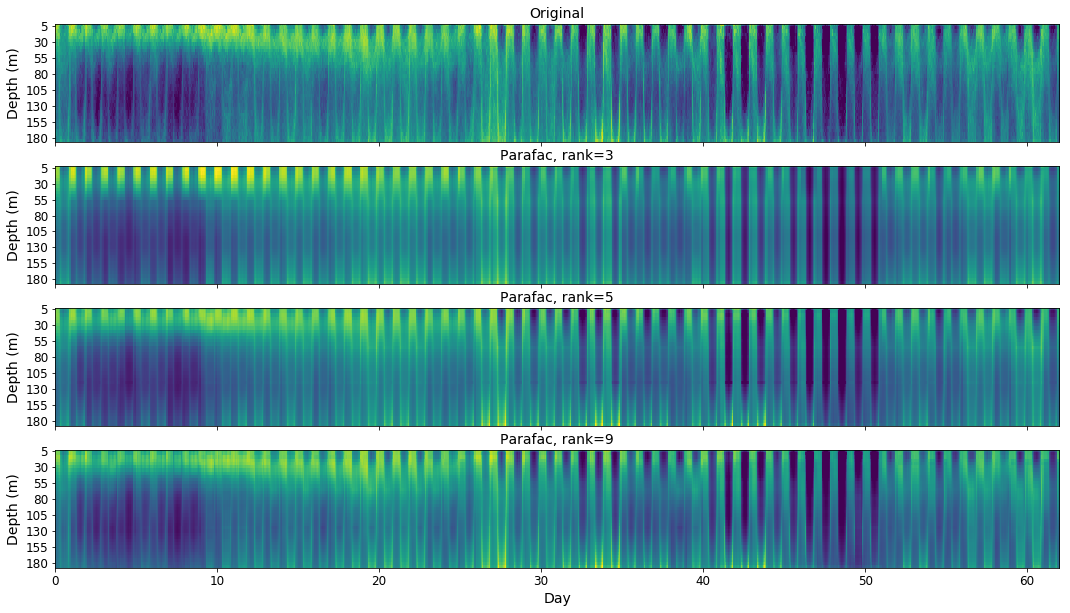

In [133]:
rank_wanted = [3,5,9]
rank_idx = np.array([np.argwhere(rank_all==x).squeeze() for x in rank_wanted])

fig,ax = plt.subplots(len(rank_wanted)+1,1,figsize=(18,10),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[:,::-1,:]),mode=1),aspect='auto',
            vmax=-57, vmin=-85)
ax[0].set_title('Original', fontsize=14)
for seq,r in enumerate(rank_idx):
    ax[seq+1].imshow(tl.unfold(tl.tensor(recons_tensor_nn[r][:,::-1,:])+sonar_tensor.min(),mode=1), aspect='auto',
                     vmax=-57, vmin=-85)
    ax[seq+1].set_title('Parafac, rank=%d'%rank_all[r], fontsize=14)
for f in range(4):
    ax[f].set_xticks(range(0,62*144,144*10))
    ax[f].set_xticklabels(range(0,62,10))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
plt.show()

## Compare regular and non-negative parafac at the same rank

### Rank = 3

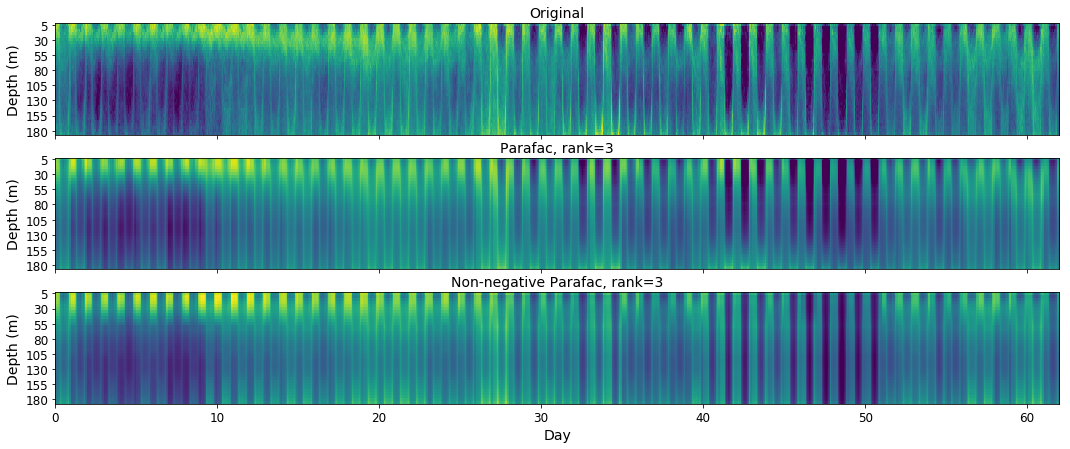

In [134]:
rank_wanted = [3]
rank_idx = np.array([np.argwhere(rank_all==x).squeeze() for x in rank_wanted]).squeeze()

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[:,::-1,:]),mode=1),aspect='auto',
            vmax=-57, vmin=-85)
ax[0].set_title('Original', fontsize=14)
ax[1].imshow(tl.unfold(tl.tensor(recons_tensor[rank_idx][:,::-1,:]),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[1].set_title('Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)
ax[2].imshow(tl.unfold(tl.tensor(recons_tensor_nn[rank_idx][:,::-1,:])+sonar_tensor.min(),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[2].set_title('Non-negative Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)

for f in range(3):
    ax[f].set_xticks(range(0,62*144,144*10))
    ax[f].set_xticklabels(range(0,62,10))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
plt.show()

It is pretty obvious from the above that with rank=3, both regular and non-negative parafac cannot capture the sub-surface pattern in the range of Day=0-25. Note the **gaps** between the bright strips. Regular parafac seems to do a little better than non-negative parafac.

Below is just a zoomed-in version of the above:

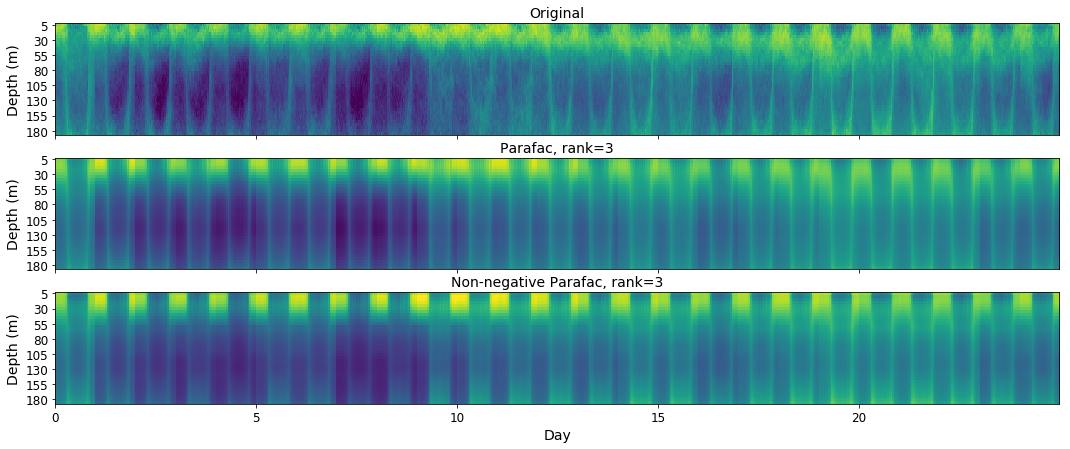

In [135]:
rank_wanted = [3]
rank_idx = np.array([np.argwhere(rank_all==x).squeeze() for x in rank_wanted]).squeeze()

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[:25,::-1,:]),mode=1),aspect='auto',
            vmax=-57, vmin=-85)
ax[0].set_title('Original', fontsize=14)
ax[1].imshow(tl.unfold(tl.tensor(recons_tensor[rank_idx][:25,::-1,:]),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[1].set_title('Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)
ax[2].imshow(tl.unfold(tl.tensor(recons_tensor_nn[rank_idx][:25,::-1,:])+sonar_tensor.min(),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[2].set_title('Non-negative Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)

for f in range(3):
    ax[f].set_xticks(range(0,25*144,144*5))
    ax[f].set_xticklabels(range(0,62,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
plt.show()

### Rank = 4

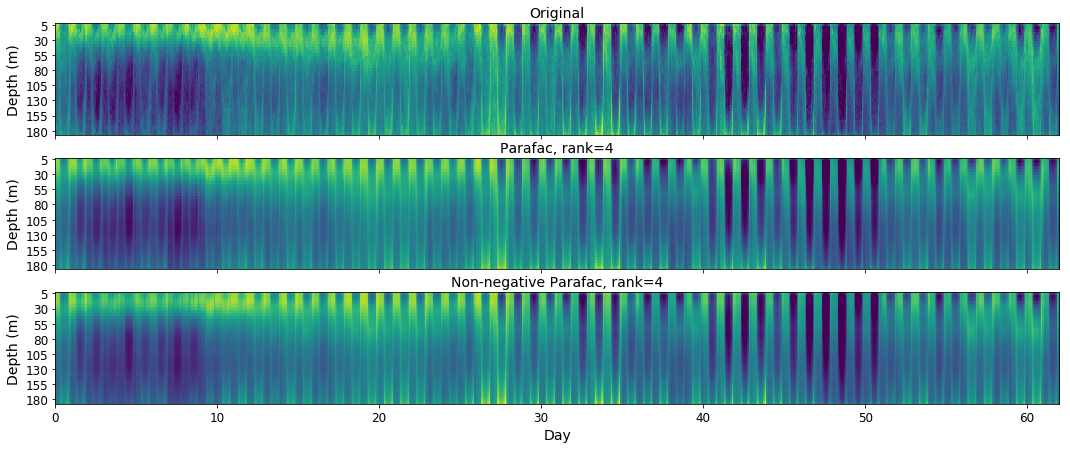

In [136]:
rank_wanted = [4]
rank_idx = np.array([np.argwhere(rank_all==x).squeeze() for x in rank_wanted]).squeeze()

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[:,::-1,:]),mode=1),aspect='auto',
            vmax=-57, vmin=-85)
ax[0].set_title('Original', fontsize=14)
ax[1].imshow(tl.unfold(tl.tensor(recons_tensor[rank_idx][:,::-1,:]),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[1].set_title('Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)
ax[2].imshow(tl.unfold(tl.tensor(recons_tensor_nn[rank_idx][:,::-1,:])+sonar_tensor.min(),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[2].set_title('Non-negative Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)

for f in range(3):
    ax[f].set_xticks(range(0,62*144,144*10))
    ax[f].set_xticklabels(range(0,62,10))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
plt.show()

The subsurface layer from Day=0-25 is captured better with rank=4. The zoomed-in below confirms this:

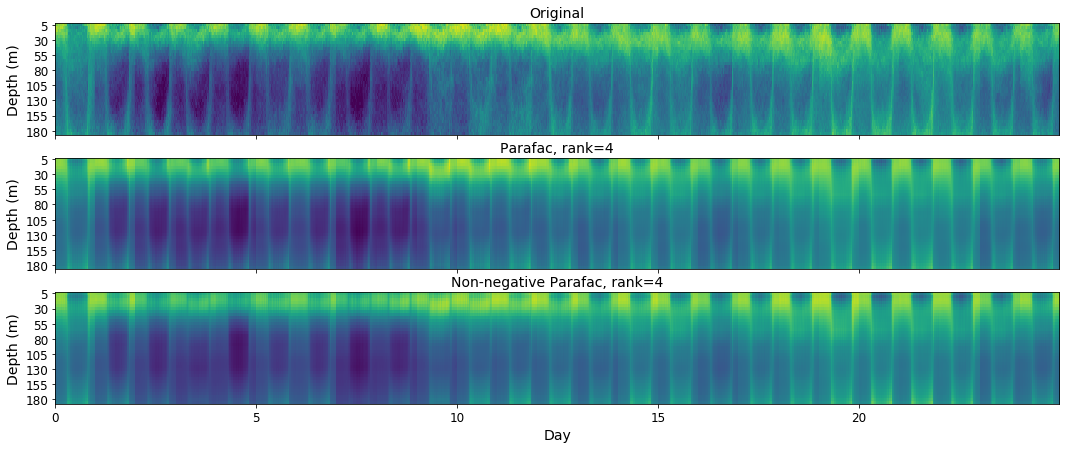

In [137]:
rank_wanted = [4]
rank_idx = np.array([np.argwhere(rank_all==x).squeeze() for x in rank_wanted]).squeeze()

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[:25,::-1,:]),mode=1),aspect='auto',
            vmax=-57, vmin=-85)
ax[0].set_title('Original', fontsize=14)
ax[1].imshow(tl.unfold(tl.tensor(recons_tensor[rank_idx][:25,::-1,:]),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[1].set_title('Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)
ax[2].imshow(tl.unfold(tl.tensor(recons_tensor_nn[rank_idx][:25,::-1,:])+sonar_tensor.min(),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[2].set_title('Non-negative Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)

for f in range(3):
    ax[f].set_xticks(range(0,25*144,144*5))
    ax[f].set_xticklabels(range(0,62,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
plt.show()

But are the other detailed pattern captured better with an even larger number of components?

### Rank = 9

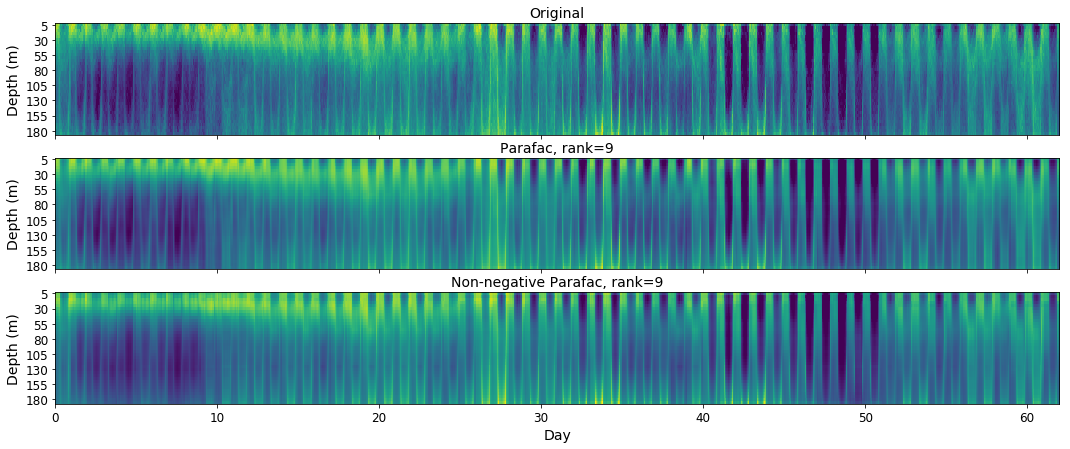

In [138]:
rank_wanted = [9]
rank_idx = np.array([np.argwhere(rank_all==x).squeeze() for x in rank_wanted]).squeeze()

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[:,::-1,:]),mode=1),aspect='auto',
            vmax=-57, vmin=-85)
ax[0].set_title('Original', fontsize=14)
ax[1].imshow(tl.unfold(tl.tensor(recons_tensor[rank_idx][:,::-1,:]),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[1].set_title('Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)
ax[2].imshow(tl.unfold(tl.tensor(recons_tensor_nn[rank_idx][:,::-1,:])+sonar_tensor.min(),mode=1), aspect='auto',
             vmax=-57, vmin=-85)
ax[2].set_title('Non-negative Parafac, rank=%d'%rank_all[rank_idx], fontsize=14)

for f in range(3):
    ax[f].set_xticks(range(0,62*144,144*10))
    ax[f].set_xticklabels(range(0,62,10))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
plt.show()

The improvements seems marginal.

Let's check this by doing a side-by-side comparison of the reconstruction from rank=[3,4,9]:

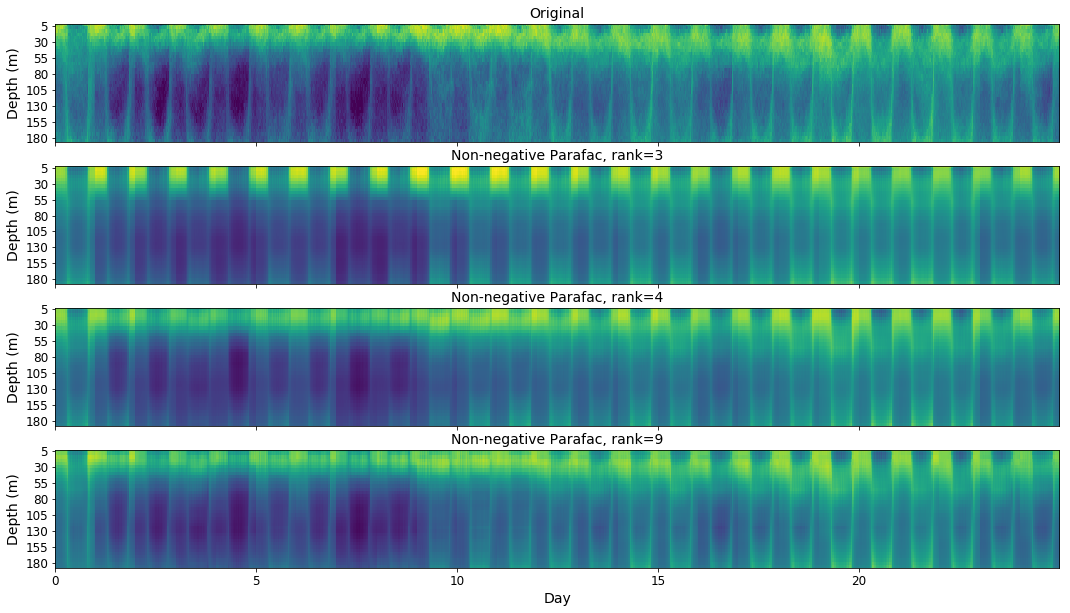

In [139]:
rank_wanted = [3,4,9]
rank_idx = np.array([np.argwhere(rank_all==x).squeeze() for x in rank_wanted])

fig,ax = plt.subplots(len(rank_wanted)+1,1,figsize=(18,10),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[:25,::-1,:]),mode=1),aspect='auto',
            vmax=-57, vmin=-85)
ax[0].set_title('Original', fontsize=14)
for seq,r in enumerate(rank_idx):
    ax[seq+1].imshow(tl.unfold(tl.tensor(recons_tensor_nn[r][:25,::-1,:])+sonar_tensor.min(),mode=1), aspect='auto',
                     vmax=-57, vmin=-85)
    ax[seq+1].set_title('Non-negative Parafac, rank=%d'%rank_all[r], fontsize=14)
for f in range(4):
    ax[f].set_xticks(range(0,25*144,144*5))
    ax[f].set_xticklabels(range(0,62,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
plt.show()

The above confirms that the improvements from rank=4 to rank=9 are marginal. There are some patterns in the middle of the water column that are captured better with rank=9, but on a grand scale there is very little difference.

Below let's look at a few example comparisons within each day, from non-negative parafac.

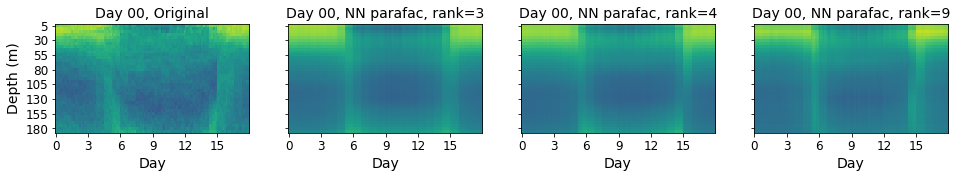

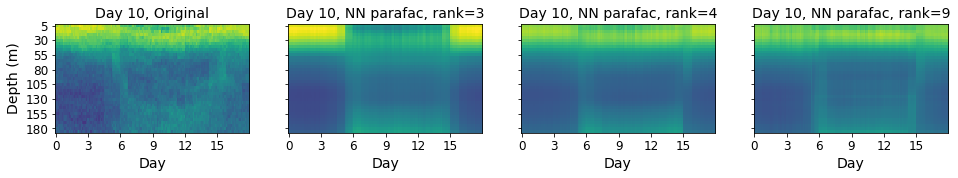

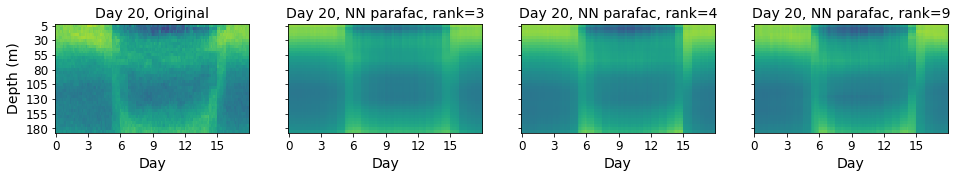

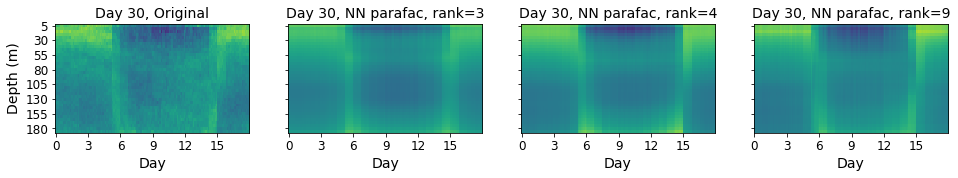

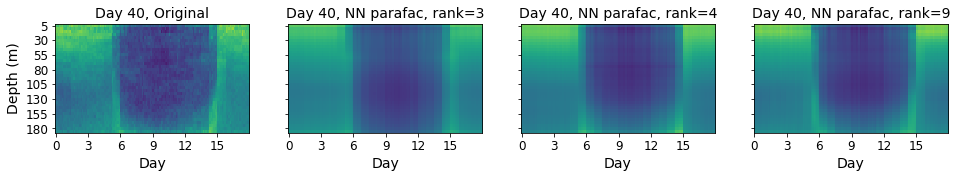

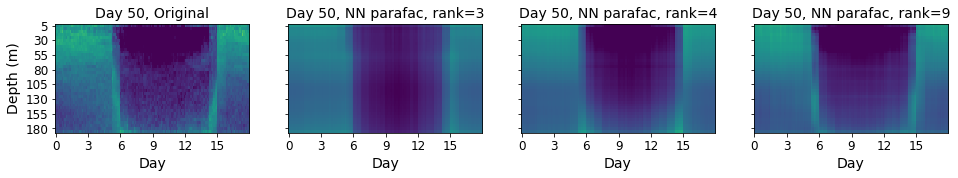

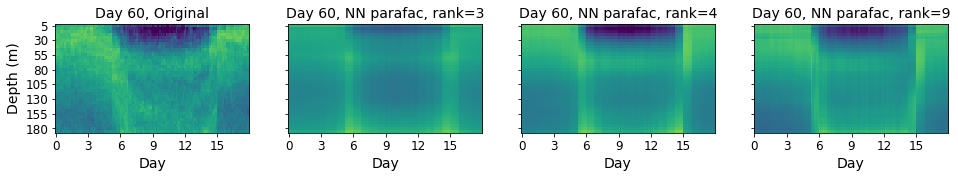

In [140]:
day_num_all = np.arange(0,61,10)
for day_num in day_num_all:
    rank_wanted = [3,4,9]
    rank_idx = np.array([np.argwhere(rank_all==x).squeeze() for x in rank_wanted])

    fig,ax = plt.subplots(1,len(rank_wanted)+1,figsize=(16,2),sharey=True)
    ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[day_num,::-1,:]),mode=1).T,
                 aspect='auto', vmax=-57, vmin=-85)
    ax[0].set_title('Day %02d, Original'%day_num, fontsize=14)
    for seq,r in enumerate(rank_idx):
        ax[seq+1].imshow(tl.unfold(tl.tensor(recons_tensor_nn[r][day_num,::-1,:]).T+sonar_tensor.min(),mode=1), 
                         aspect='auto', vmax=-57, vmin=-85)
        ax[seq+1].set_title('Day %02d, NN parafac, rank=%d'%(day_num,rank_all[r]), fontsize=14)
    for f in range(4):
        ax[f].set_xticks(range(0,144,24))
        ax[f].set_xticklabels(range(0,24,3))
        ax[f].set_yticks(range(0,37,5))
        ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
        plt.setp(ax[f].get_xticklabels(), fontsize=12)
        plt.setp(ax[f].get_yticklabels(), fontsize=12)
        if ax[f].is_first_col():
            ax[f].set_ylabel('Depth (m)',fontsize=14)
        ax[f].set_xlabel('Day',fontsize=14)    
    plt.show()

## Iterate number of components and check clusters across days

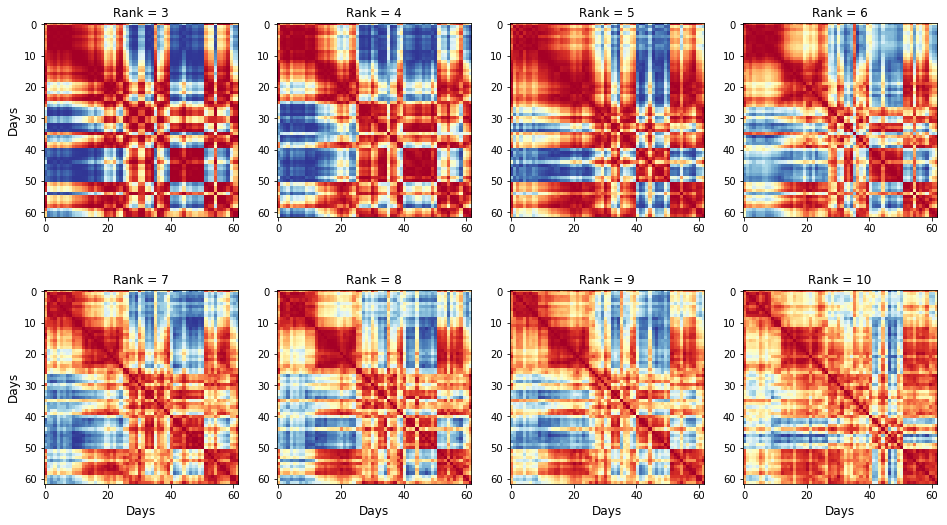

In [151]:
fig,ax = plt.subplots(2,4,figsize=(16,9))
for seq,r in enumerate(rank_all):
    k = factors_kruskal_nn[seq][0].T
    k_norm = k.T-k.min(axis=1)
    k_norm = k_norm/k_norm.max(axis=0)
    i,j = np.divmod(seq,4)
    
    # Similarity between days
    ax[i,j].imshow(np.corrcoef(k_norm),cmap='RdYlBu_r')
    ax[i,j].set_title('Rank = %d'%r)
    if ax[i,j].is_last_row():
        ax[i,j].set_xlabel('Days',fontsize=12)
    if ax[i,j].is_first_col():
        ax[i,j].set_ylabel('Days',fontsize=12)
plt.show()

## Similarity across the components?

Perhaps the similarity of each component should be calculated across all dimensions?

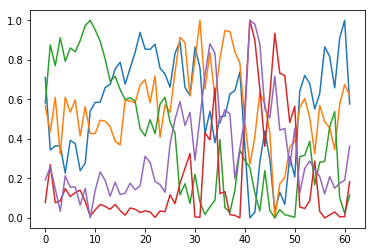

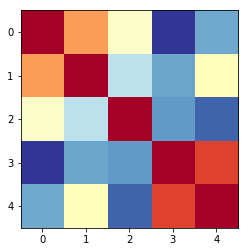

In [192]:
k = factors_kruskal_nn[2][0].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)

plt.plot(k_norm)
plt.show()

plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.show()

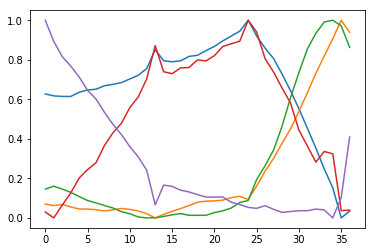

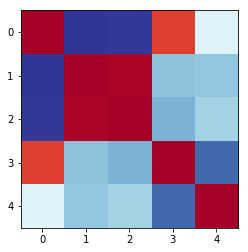

In [193]:
k = factors_kruskal_nn[2][1].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)

plt.plot(k_norm)
plt.show()

plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.show()

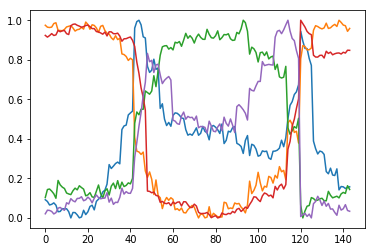

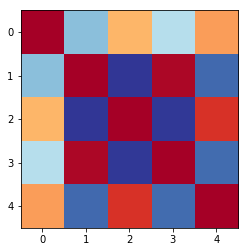

In [194]:
k = factors_kruskal_nn[2][2].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)

plt.plot(k_norm)
plt.show()

plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.show()

In [187]:
kk = []
for fac in range(3):
    k = factors_kruskal_nn[0][fac].T
    k_norm = k.T-k.min(axis=1)
    k_norm = k_norm/k_norm.max(axis=0)
    kk.append(k_norm)
kk_np = np.array(kk[0])
kk_np = np.vstack((kk_np,np.array(kk[1])))
kk_np = np.vstack((kk_np,np.array(kk[2])))

In [188]:
kk_np.shape

(243, 3)

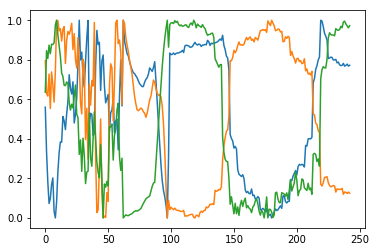

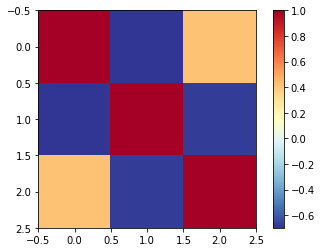

In [190]:
plt.plot(kk_np)
plt.show()

plt.imshow(np.corrcoef(kk_np.T),cmap='RdYlBu_r')
plt.colorbar()
plt.show()

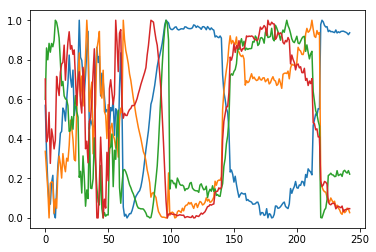

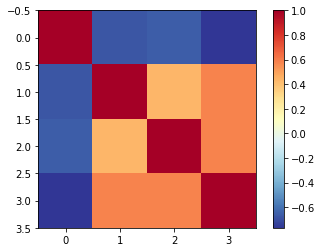

In [191]:
kk = []
for fac in range(3):
    k = factors_kruskal_nn[1][fac].T
    k_norm = k.T-k.min(axis=1)
    k_norm = k_norm/k_norm.max(axis=0)
    kk.append(k_norm)
kk_np = np.array(kk[0])
kk_np = np.vstack((kk_np,np.array(kk[1])))
kk_np = np.vstack((kk_np,np.array(kk[2])))

kk_np.shape

plt.plot(kk_np)
plt.show()

plt.imshow(np.corrcoef(kk_np.T),cmap='RdYlBu_r')
plt.colorbar()
plt.show()